In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Flatten, Dropout
import matplotlib.pyplot as plt
# import seaborn as sns

# Load and preprocess the dataset
data_dir = '/kaggle/input/carlogo/Final Dataset 1'
target_size = (224, 224)  # ResNet50 input size
batch_size = 32

2024-04-04 08:12:10.832575: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 08:12:10.832716: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 08:12:11.001260: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

import tensorflow as tf

gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
    tf.config.experimental.set_visible_devices(gpu_devices[1], 'GPU')
    print(gpu_devices[1])
    print('Success')



PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Success


In [3]:
def load_images_from_directory(data_dir, target_size):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            
            # Attempt to read the image
            image = cv2.imread(image_path)
            
            # Check if image reading was successful
            if image is None:
                print(f"Error: Unable to read image file: {image_path}")
                continue
            
            # Resize the image
            image = cv2.resize(image, target_size)
            
            images.append(image)
            labels.append(class_name)
    return np.array(images), np.array(labels)


# Load images and labels
images, labels = load_images_from_directory(data_dir, target_size)

# Encode class labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split data into train, temp, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocess images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Convert labels to one-hot encoding
num_classes = len(np.unique(labels_encoded))
y_train = np.eye(num_classes)[np.array(y_train).astype(int)]
y_val = np.eye(num_classes)[np.array(y_val).astype(int)]
y_test = np.eye(num_classes)[np.array(y_test).astype(int)]

# Load ResNet50 base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = True

# Add classification layers on top of the ResNet50 base
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Define filepath for model checkpoint
filepath = 'ResNet50.keras'

# Define callbacks
callbacks_list = [
    EarlyStopping(monitor='val_accuracy', patience=10, verbose=1),
    ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)
]


In [5]:
# Train the model
epochs = 50
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=1,callbacks=callbacks_list)


Epoch 1/50


I0000 00:00:1712218555.602641      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712218555.701604      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


131/132 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.4799 - loss: 1.3983

W0000 00:00:1712218630.610070      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.4808 - loss: 1.3959

W0000 00:00:1712218636.344126      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.18122, saving model to ResNet50.keras


W0000 00:00:1712218643.441082      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 162s 678ms/step - accuracy: 0.4816 - loss: 1.3935 - val_accuracy: 0.1812 - val_loss: 2.4286 - learning_rate: 0.0010
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.7924 - loss: 0.5716
Epoch 2: val_accuracy improved from 0.18122 to 0.21878, saving model to ResNet50.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 306ms/step - accuracy: 0.7925 - loss: 0.5714 - val_accuracy: 0.2188 - val_loss: 1.7252 - learning_rate: 0.0010
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8627 - loss: 0.3844
Epoch 3: val_accuracy did not improve from 0.21878
132/132 ━━━━━━━━━━━━━━━━━━━━ 38s 291ms/step - accuracy: 0.8628 - loss: 0.3843 - val_accuracy: 0.1989 - val_loss: 1.7186 - learning_rate: 0.0010
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8951 - loss: 0.2905
Epoch 4: val_accuracy did not improve from 0.21878
132/132 ━━━━━━━━━━━━━━━━━━━━ 39s 292ms/step - accuracy: 0.8951 - loss: 0.2905 - val_accuracy: 0.2155 - val_loss: 1

In [6]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9556 - loss: 0.1472
Test accuracy: 0.960220992565155


In [7]:
# Predict classes for test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

 3/29 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step

W0000 00:00:1712220331.981540      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step


W0000 00:00:1712220337.726204      84 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


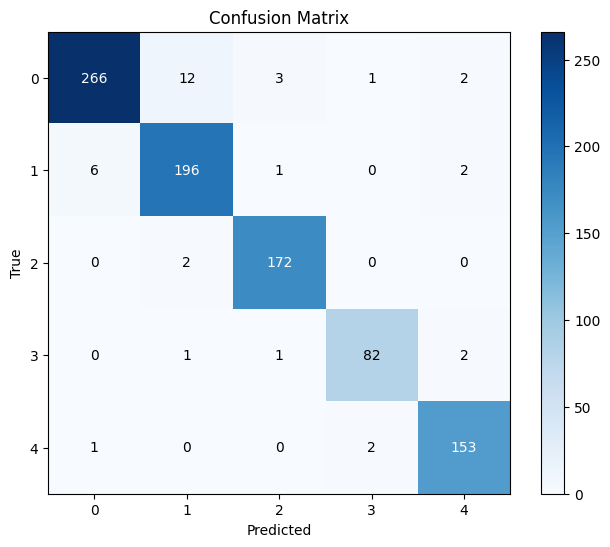

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming cm is your confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()

# Add annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [9]:
# Classification report
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       284
           1       0.93      0.96      0.94       205
           2       0.97      0.99      0.98       174
           3       0.96      0.95      0.96        86
           4       0.96      0.98      0.97       156

    accuracy                           0.96       905
   macro avg       0.96      0.96      0.96       905
weighted avg       0.96      0.96      0.96       905



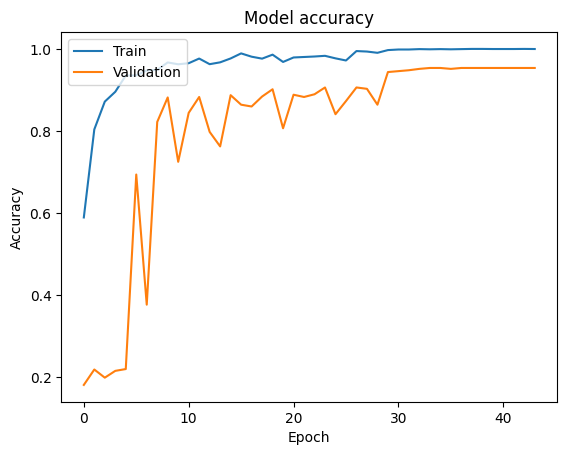

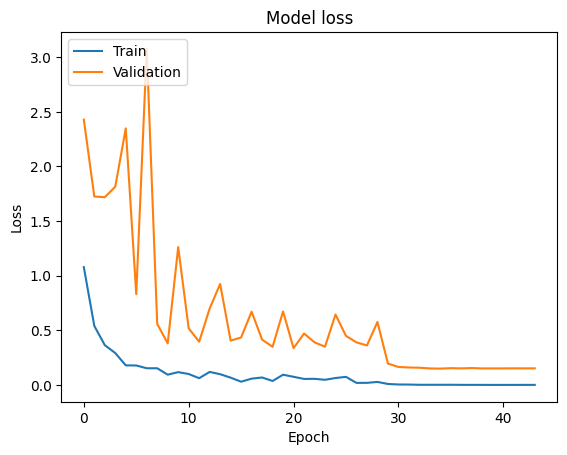

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step


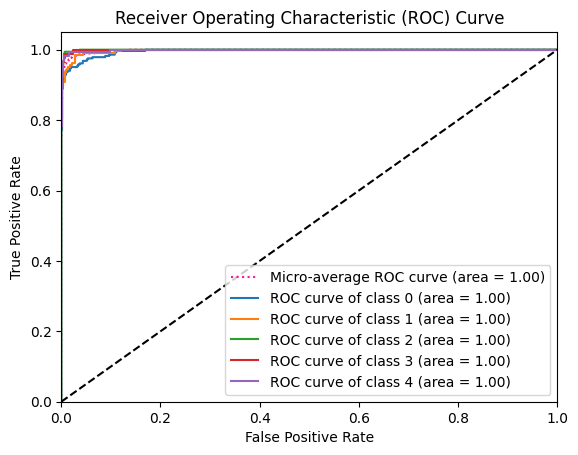

In [11]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for test set
y_pred_prob = model.predict(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]), color='deeppink', linestyle=':')
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
